In [1]:
import numpy as np
from scipy.linalg import eigh
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm.notebook import tqdm, trange
import torch.nn.functional as F
import torch.nn as nn
import torch

import os

from transformers import AutoTokenizer, AutoModelForCausalLM
from mteb import MTEB

torch.manual_seed(42)

In [2]:
ROOT_DIR = os.getenv("ROOT_DIR", "..")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
model_name = "meta-llama/Llama-2-7b-hf"
dataset_name = "Skylion007/openwebtext"
model_suffix = model_name.split("/")[-1]
dataset_suffix = dataset_name.split("/")[-1]
data_dir = f"{ROOT_DIR}/data/{dataset_suffix}_{model_suffix}"
model_output_dir = f"{ROOT_DIR}/saved_models/{dataset_suffix}_{model_suffix}"
hidden_states = torch.load(f"{data_dir}/hidden_states.pt")
embeddings = torch.load(f"{data_dir}/embeddings_all-mpnet-base-v2.pt")
embeddings = embeddings[:hidden_states.shape[0]]

embeddings = embeddings.float()
hidden_states = hidden_states.float()
sem_eval = False

/tmp/ipykernel_799723/1830846187.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hidden_states = torch.load(f"{data_dir}/hidden_states.pt")
/tmp/ipykernel_799723/1830846

In [4]:
def ridge_regression(X, Y, alpha):
    # l2 normalization
    Y = F.normalize(Y, dim=1)
    d_in = X.shape[1]
    I = torch.eye(d_in, device=X.device)
    W = torch.linalg.solve(X.T @ X + alpha * I, X.T @ Y)
    return W

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LinearProjector(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.proj = nn.Linear(input_dim, output_dim,
                              bias=False)

    def forward(self, x):
        return self.proj(x)
    
def similarity_matrix(x):
    x = F.normalize(x, dim=-1)
    sim = x @ x.T  # Cosine similarity
    # Exclude self-similarity by setting diagonal to -inf
    mask = torch.eye(sim.size(0), device=sim.device, dtype=torch.bool)
    sim = sim.masked_fill(mask, -1e9)  # Exclude self-similarity
    return sim


def distillation_loss(projected, target, temperature=0.07):
    sim_proj = similarity_matrix(projected) / temperature
    sim_tgt = similarity_matrix(target) / temperature

    p = F.log_softmax(sim_proj, dim=-1)
    q = F.softmax(sim_tgt, dim=-1)
    return F.kl_div(p, q, reduction='batchmean')

def train_model(loss_fn, output_dim, num_epochs=10, lr=1e-3, batch_size=512, temperature=0.07):
    model = LinearProjector(hidden_states.shape[1], output_dim).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    dataset = torch.utils.data.TensorDataset(hidden_states, embeddings)
    # Split dataset into train and test sets
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, test_size])
    # Create DataLoader for the training set
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    # Create DataLoader for the test set
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        model.train()
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            x_proj = model(x)


            loss = loss_fn(x_proj, y, temperature=temperature)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_loss)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_dataloader:
                x, y = x.to(device), y.to(device)
                x_proj = model(x)

                loss = loss_fn(x_proj, y, temperature=temperature)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        print(
            f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        val_losses.append(avg_val_loss)

    # Plot the loss
    plt.plot(range(num_epochs), train_losses)
    plt.plot(range(num_epochs), val_losses)
    plt.legend(["Train Loss", "Validation Loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.show()

    return model


Training with contrastive distillation loss and temperature: 0.07
Epoch 1: Train Loss = 0.9318, Val Loss = 0.8850
Epoch 2: Train Loss = 0.8720, Val Loss = 0.8675
Epoch 3: Train Loss = 0.8562, Val Loss = 0.8586
Epoch 4: Train Loss = 0.8467, Val Loss = 0.8544
Epoch 5: Train Loss = 0.8419, Val Loss = 0.8496
Epoch 6: Train Loss = 0.8375, Val Loss = 0.8484
Epoch 7: Train Loss = 0.8344, Val Loss = 0.8453
Epoch 8: Train Loss = 0.8326, Val Loss = 0.8442
Epoch 9: Train Loss = 0.8305, Val Loss = 0.8430
Epoch 10: Train Loss = 0.8284, Val Loss = 0.8427
Epoch 11: Train Loss = 0.8268, Val Loss = 0.8420
Epoch 12: Train Loss = 0.8269, Val Loss = 0.8418
Epoch 13: Train Loss = 0.8252, Val Loss = 0.8407
Epoch 14: Train Loss = 0.8246, Val Loss = 0.8401
Epoch 15: Train Loss = 0.8239, Val Loss = 0.8402


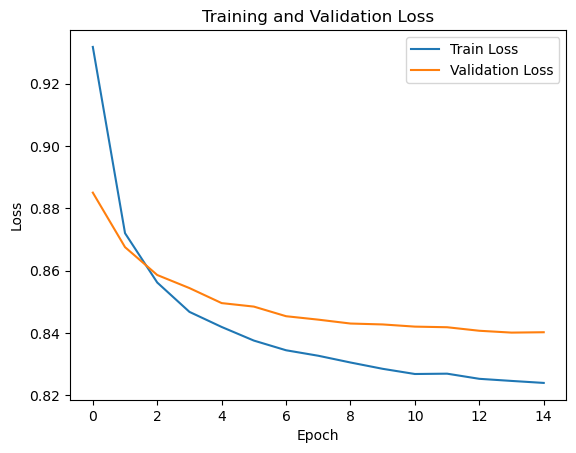

In [7]:
temperature = 0.07
# For KL distillation
print("\nTraining with contrastive distillation loss and temperature:", temperature)
distillation_model = train_model(
    distillation_loss, output_dim=embeddings.shape[1], num_epochs=15, lr=1e-4, batch_size=256, temperature=temperature)

In [8]:


class LLaMAEmbeddingModel:
    def __init__(self, model, tokenizer, normalize_embeddings=True, mean_pooling=True, batch_size=8, W_aug=torch.nn.Identity()):
        self.model = model
        self.tokenizer = tokenizer
        self.model.eval()
        self.model.lm_head = torch.nn.Identity()
        self.normalize_embeddings = normalize_embeddings
        self.mean_pooling = mean_pooling
        self.batch_size = batch_size
        self.W_aug = W_aug.cuda()

    def encode(self, sentences, **kwargs):
        all_embeddings = []
        for i in range(0, len(sentences), self.batch_size):
            batch = sentences[i:i+self.batch_size]
            inputs = self.tokenizer(
                batch, return_tensors='pt', padding=True, truncation=True).to(self.model.device)
            with torch.no_grad():
                outputs = self.model(**inputs).logits

                outputs = outputs.float()

                # Mean pooling
                if self.mean_pooling:
                    attention_mask = inputs['attention_mask']
                    embeddings = outputs * attention_mask.unsqueeze(-1)
                    embeddings = embeddings.sum(
                        1) / attention_mask.sum(1).unsqueeze(-1)
                else:
                    # get last token embedding
                    embeddings = outputs[:, -1, :]
                    # Apply ridge regression projection
                    embeddings = self.W_aug(embeddings)

                if self.normalize_embeddings:
                    embeddings = torch.nn.functional.normalize(
                        embeddings, p=2, dim=1)
                all_embeddings.append(embeddings.cpu().numpy())
        return np.vstack(all_embeddings)

In [9]:
sts_tasks = [
    "STSBenchmark",   # Standard semantic similarity benchmark
    "SICK-R",         # Semantic relatedness from the SICK dataset
    "STS12",
    "STS13",
    "STS14",
    "STS15",
    "STS16",
]

evaluation = MTEB(tasks=sts_tasks)


def eval(eval_model):
    results = evaluation.run(eval_model, output_folder=None)
    score = np.stack([result.scores['test'][0]['main_score']
                     for result in results])
    return score

/home/miroojin/miniconda3/envs/venv/lib/python3.12/site-packages/mteb/evaluation/MTEB.py:121: UserWarning: Passing task names as strings is deprecated and will be removed in 2.0 release. Please use `tasks = mteb.get_tasks(tasks=[...])` method to get tasks instead.
  warnings.warn(


In [10]:
if sem_eval:
    model_name = 'meta-llama/Llama-2-7b-hf'
    model = AutoModelForCausalLM.from_pretrained(
        model_name,  device_map="auto", torch_dtype=torch.bfloat16)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

In [11]:
W_ridge_align = ridge_regression(hidden_states, embeddings, alpha=1e-3)

W_ridge_model = torch.nn.Linear(
    W_ridge_align.shape[0], W_ridge_align.shape[1], bias=False)
W_ridge_model.weight.data = W_ridge_align.T
if sem_eval:
    eval_model = LLaMAEmbeddingModel(
    model, tokenizer, normalize_embeddings=False, mean_pooling=False, W_aug=W_ridge_model)

    print(eval(eval_model))

In [12]:
if sem_eval:
    eval_model = LLaMAEmbeddingModel(
        model, tokenizer, normalize_embeddings=False, mean_pooling=False, W_aug=nn.Identity())
    print(eval(eval_model))

In [13]:
if sem_eval:
    eval_model = LLaMAEmbeddingModel(
        model, tokenizer, normalize_embeddings=False, mean_pooling=False, W_aug=distillation_model.proj)
    print(eval(eval_model))

In [14]:
os.makedirs(model_output_dir, exist_ok=True)


In [15]:
distillation_weight = distillation_model.proj.weight.data

torch.save(distillation_weight,
           f"{model_output_dir}/align_distillation.pt")

In [16]:
W_ridge_weight = W_ridge_model.weight.data

torch.save(W_ridge_weight, f"{model_output_dir}/align_ridge.pt")